The total cost of a prediction model the sum of Cost_1 multiplied by the number of Instances with type 1 failure and Cost_2 with the number of instances with type 2 failure, resulting in a Total_cost. In this case Cost_1 refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while Cost_2 refer to the cost of missing a faulty truck, which may cause a breakdown.

Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.

#### From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.

### Challenges and other objectives
* Need to Handle many Null values in almost all columns
* No low-latency requirement.
* Interpretability is not important.
* Misclassification leads the unecessary repair costs.

#### Data Collection and Getting Information 

In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings

from sklearn.model_selection import train_test_split,cross_val_score,RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_auc_score,f1_score

warnings.filterwarnings('ignore')
%matplotlib inline 

In [3]:
df = pd.read_csv("aps_failure_training_set1.csv",na_values="na")
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,182.0,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2926.0,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN


In [4]:
df.shape

(36188, 171)

In [5]:
# Check unique values of target 
df['class'].value_counts()

class
neg    35188
pos     1000
Name: count, dtype: int64

In [6]:
# define numerical and categorical columns 
numerical_columns = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_columns = [feature for feature in df.columns if df[feature].dtype == 'O']

print(f"We have {len(numerical_columns)} numerical columns: {numerical_columns}")
print(f"We have {len(categorical_columns)} categorical columns: {categorical_columns}")

We have 170 numerical columns: ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000', 

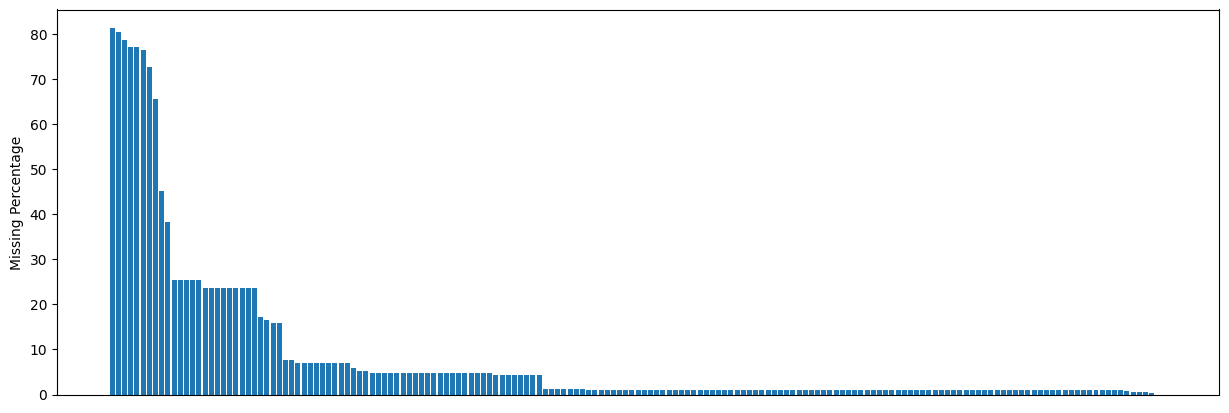

In [7]:
# Checking Missing Values 
plt.figure(figsize=(15,5))
missing = df.isnull().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0,ascending=False)

plt.bar(missing.index,missing.values.T[0])
plt.xticks([])
plt.ylabel("Missing Percentage")
plt.show()

In [8]:
# Removing the Columns having Missing percentage > 70
dropcols = missing[missing[0] > 70]
dropcols 

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
ab_000,77.086327
cr_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [9]:
df.drop(columns=dropcols.index,axis=1,inplace=True)
df.shape

(36188, 164)

In [10]:
missing_values = df.isnull().sum()
total_cells = df.shape[0]*df.shape[1]
total_missing = missing_values.sum()

print(f"Percentage of Total Missing cells: {(total_missing/total_cells)*100}")

Percentage of Total Missing cells: 5.37059852747306


Positive: 1000, Negative: 35188


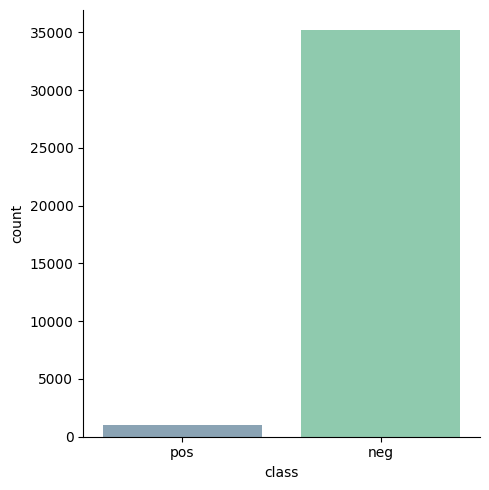

In [13]:
# Visualization of Target variable 
pos = df[df['class'] == 'pos'].shape[0]
neg = df[df['class'] == 'neg'].shape[0]
print(f"Positive: "+ str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df,x='class',kind='count',palette='viridis',alpha=0.6)

* Data is highy Imbalanced

#### EDA

In [14]:
df.describe()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,3.618800e+04,3.404700e+04,2.698800e+04,34601.000000,34601.000000,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,...,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,34458.000000,34459.000000
mean,6.591016e+04,3.535223e+08,3.185447e+05,7.234300,11.606543,1.952347e+02,1.508277e+03,1.250718e+04,1.156928e+05,5.068253e+05,...,4.853621e+05,2.293208e+05,4.837846e+05,4.401019e+05,3.686943e+05,3.718051e+05,1.485117e+05,8.897664e+03,0.083464,0.209234
std,1.641238e+05,7.926486e+08,5.225398e+07,186.437282,234.405353,1.852862e+04,4.371360e+04,1.801543e+05,8.853380e+05,2.472058e+06,...,1.254188e+06,5.948054e+05,1.251106e+06,1.331837e+06,1.220688e+06,1.722483e+06,5.153265e+05,5.316375e+04,3.789020,8.613915
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.660000e+02,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.180000e+02,...,2.986000e+03,1.190000e+03,2.732000e+03,3.680000e+03,5.660000e+02,1.180000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.102600e+04,1.520000e+02,1.280000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.798000e+03,...,2.378500e+05,1.137840e+05,2.263560e+05,1.952480e+05,9.559400e+04,4.296600e+04,4.278000e+03,0.000000e+00,0.000000,0.000000
75%,5.006850e+04,9.640000e+02,4.320000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.224600e+04,...,4.470120e+05,2.222860e+05,4.748680e+05,4.103280e+05,2.791920e+05,1.706080e+05,1.432300e+05,2.018000e+03,0.000000,0.000000
max,2.746564e+06,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,2.904730e+07,5.396293e+07,...,3.123272e+07,1.676929e+07,2.747758e+07,5.743524e+07,3.160781e+07,3.727856e+07,1.926740e+07,3.810078e+06,362.000000,1146.000000


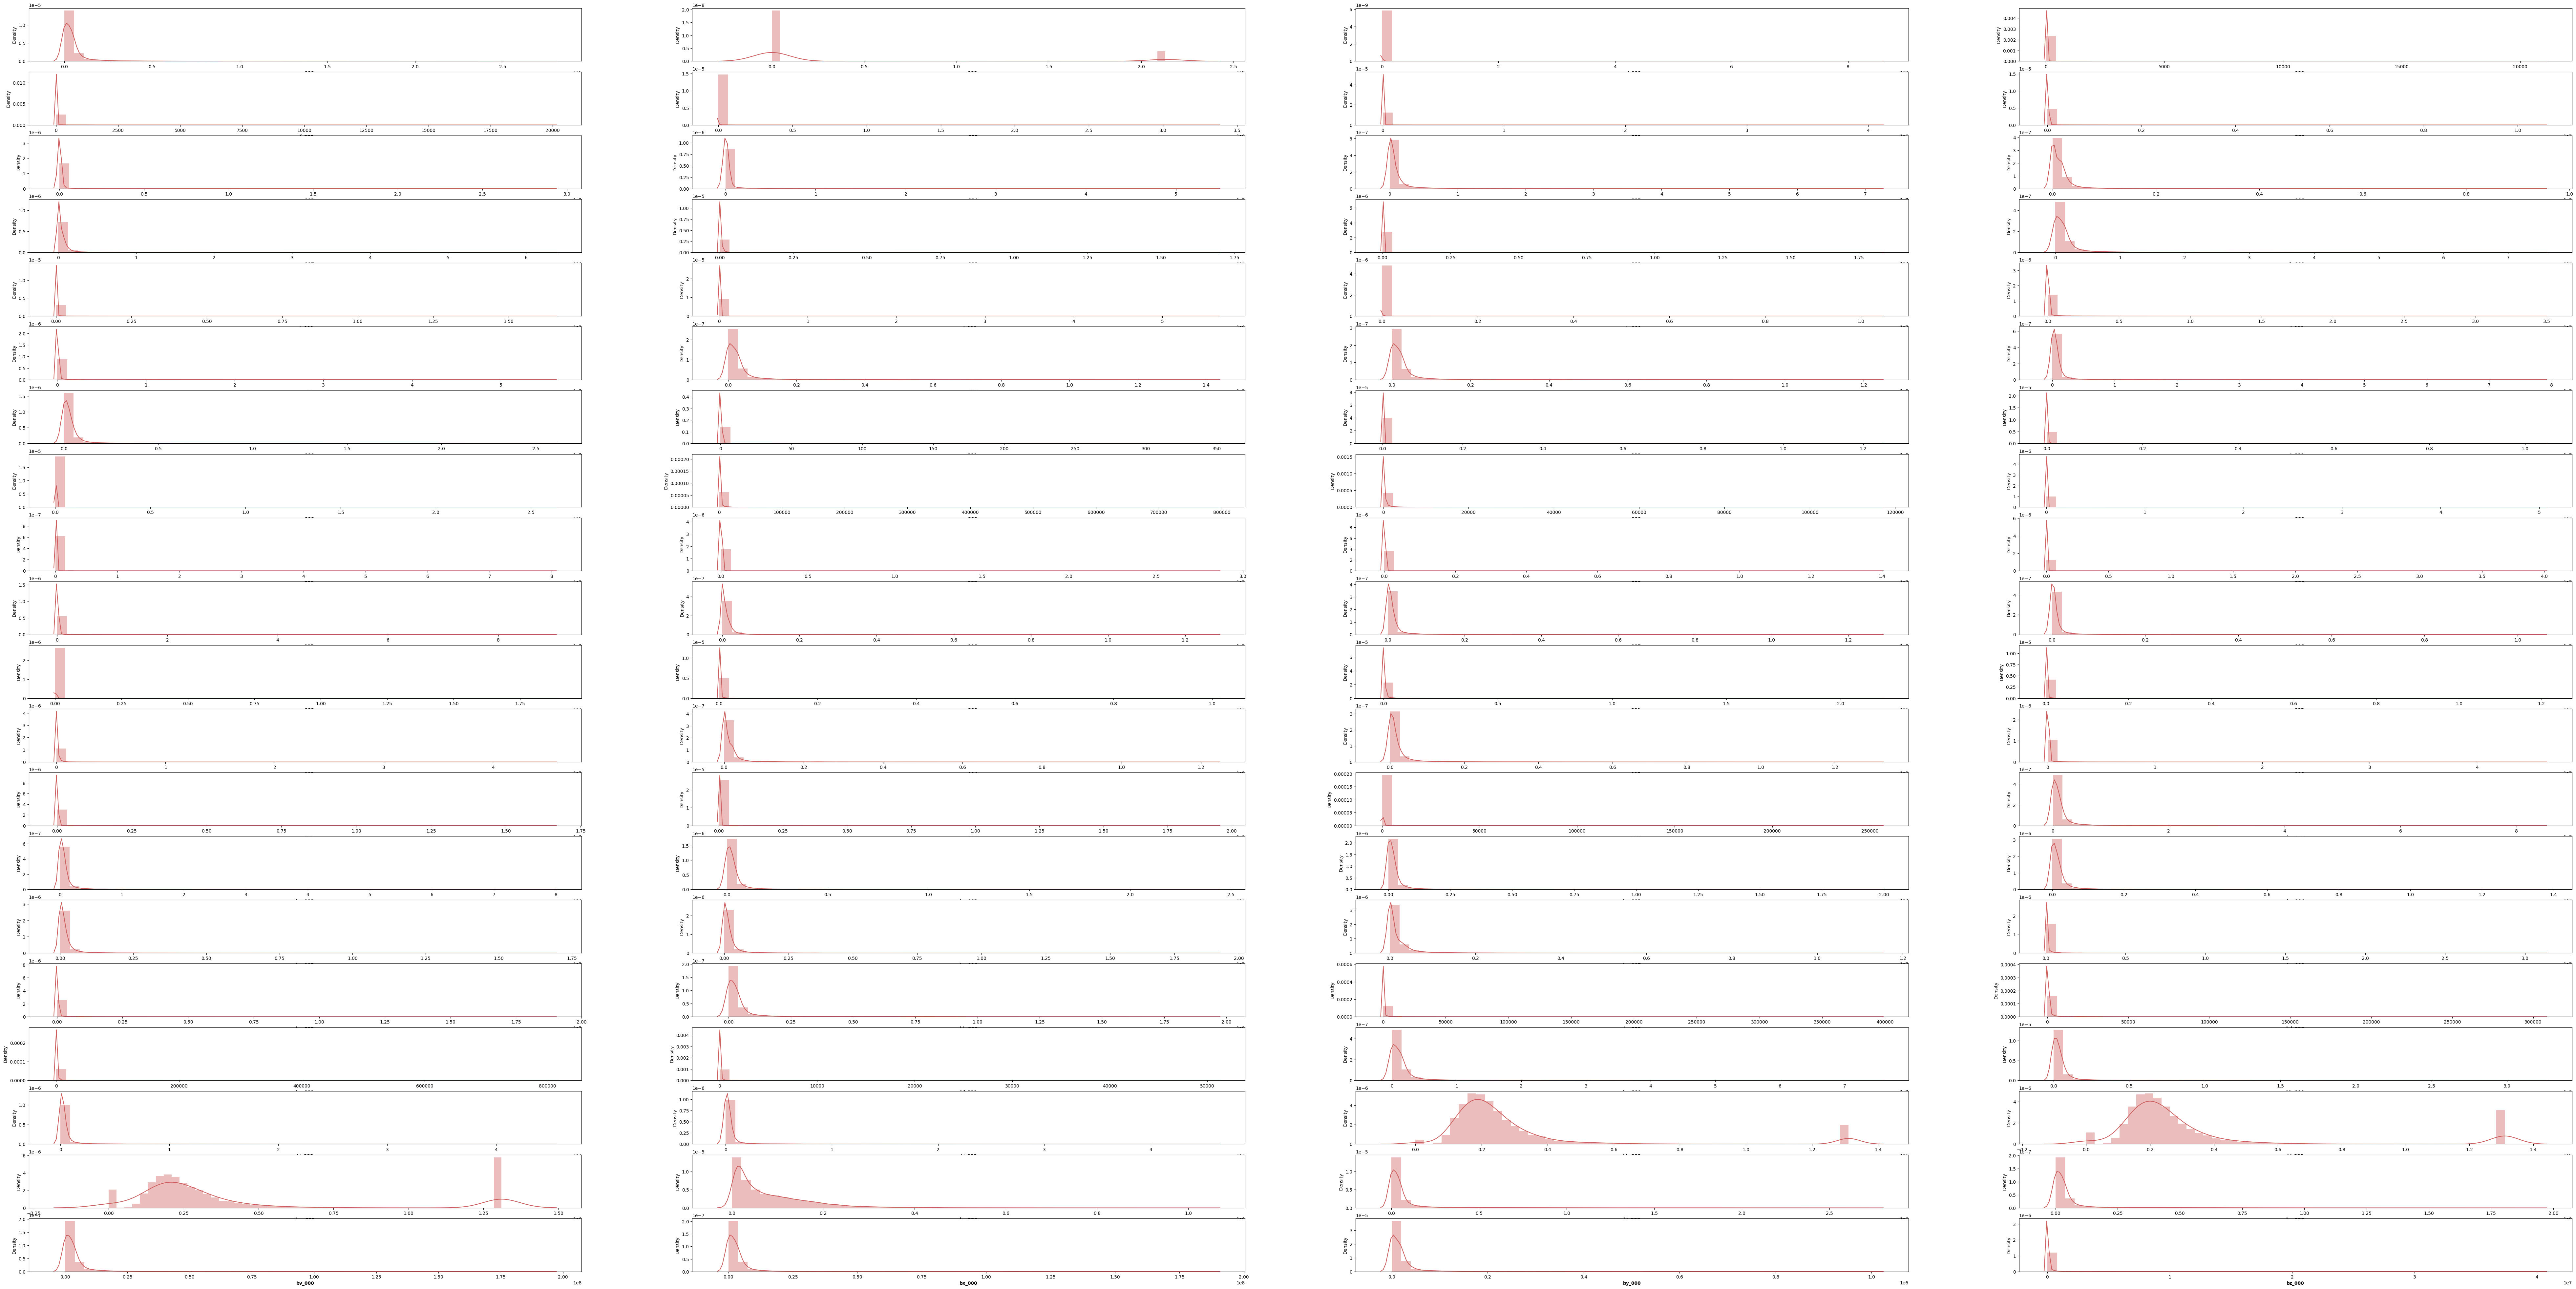

In [15]:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']

plt.figure(figsize=(100,50))
for i, col in enumerate(numeric_features[:80]):
    plt.subplot(20,4,i+1)
    sns.distplot(x=df[col],color='indianred')
    plt.xlabel(col,weight='bold')

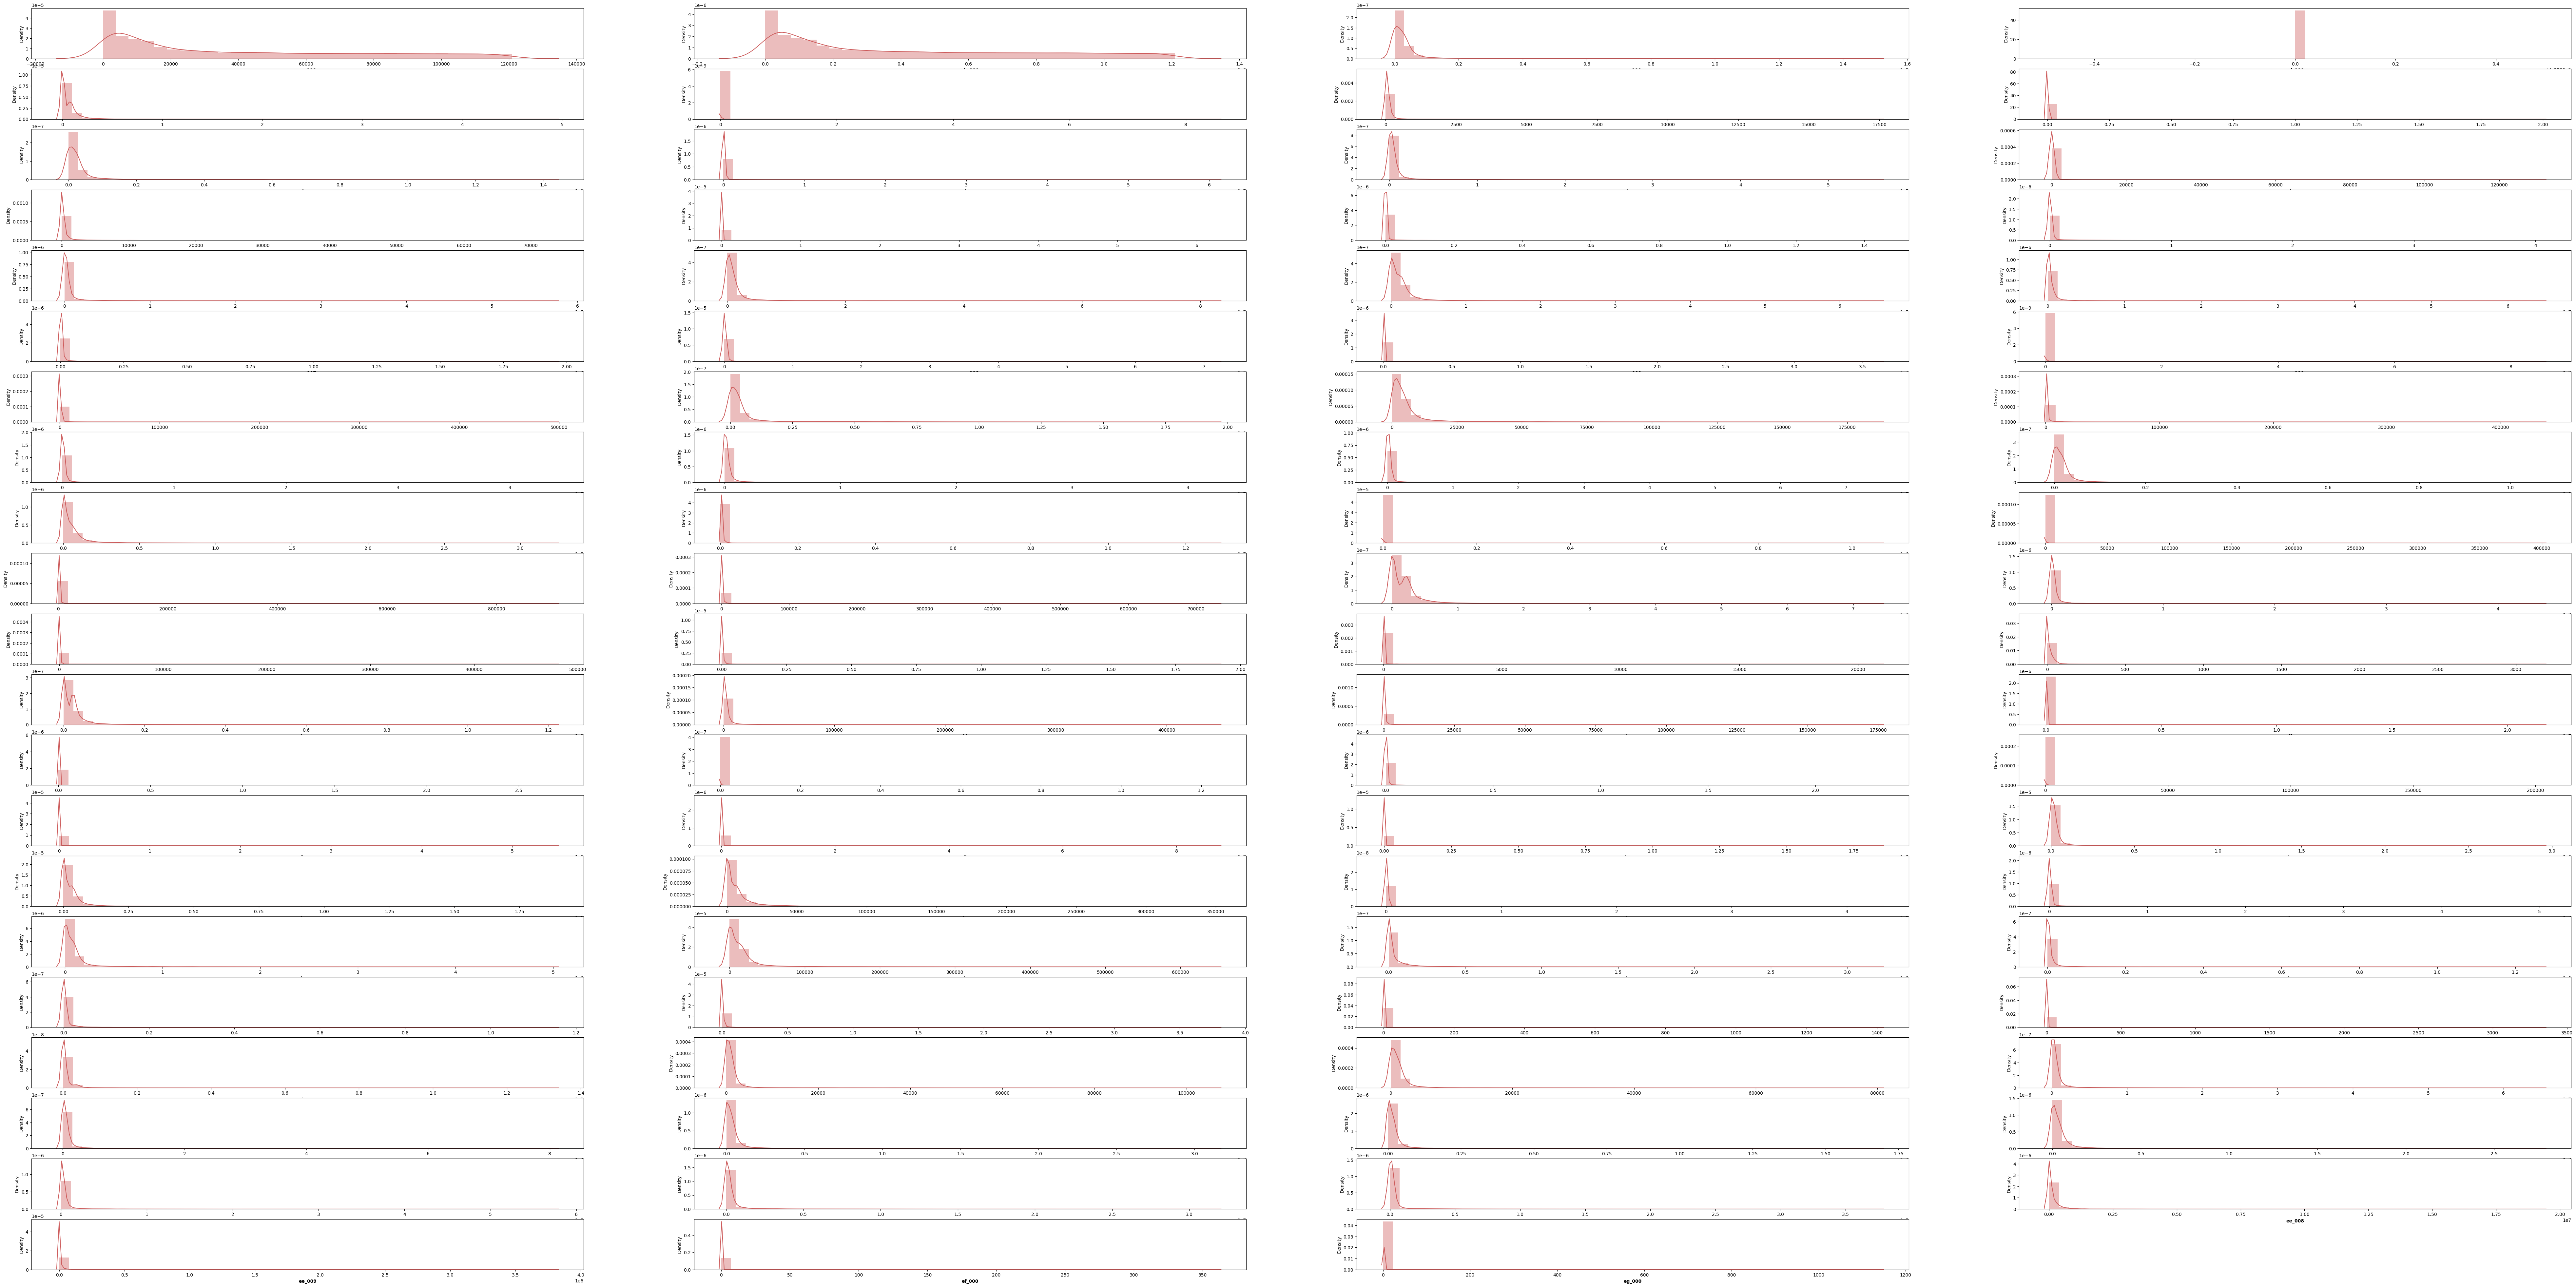

In [16]:
plt.figure(figsize=(100,50))
for i, col in enumerate(numeric_features[80:]):
    plt.subplot(21,4,i+1)
    sns.distplot(x=df[col],color='indianred')
    plt.xlabel(col,weight='bold')

* As per the above plot most of the features are not normally distributed.
* Transformation of data is needed.

#### Functions for Modelling and Evaluation

In [17]:
def evaluate(true,predicted):
    acc = accuracy_score(true,predicted)
    f1 = f1_score(true,predicted)
    precision = precision_score(true,predicted)
    recall = recall_score(true,predicted)
    roc_auc = roc_auc_score(true,predicted)
    return acc, f1 , precision, recall, roc_auc

In [18]:
def total_cost(y_true,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [35]:
def evaluate_model(X,y,models):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    cost_list = []
    models_list = []
    accuracy_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train,y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        model_train_accuracy, model_train_f1,model_train_precision,model_train_recall,model_train_rocauc_score = evaluate(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)

        model_test_accuracy,model_test_f1,model_test_precision, model_test_recall,model_test_rocauc_score=evaluate(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)
        
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')

        cost_list.append(test_cost)
        print('='*35)
        print('\n')

    report = pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

In [20]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [21]:
X = df.drop('class',axis=1)
y = df['class']

In [22]:
y = y.replace({'pos':1,'neg':0})
y.value_counts()

class
0    35188
1     1000
Name: count, dtype: int64

#### Experiment1: KNN Imputer For Null Values 

* Scaling the data using Robust scaler
* Since most of the independent variables are not normally distributed we cannot use Standardscaler
* Because most of the feature has outliers. So Minmax will scale data according to Max values which is outlier.
* This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [24]:
rs = RobustScaler()
X1 = rs.fit_transform(X)

* KNNImputer by scikit-learn is a widely used method to impute missing values. 
* It is widely being observed as a replacement for traditional imputation techniques.
* KNNImputer helps to impute missing values present in the observations by finding the nearest neighbors with the Euclidean distance matrix.

In [ ]:
results = []
imputer = KNNImputer(n_neighbors=5,weights='uniform',metric='nan_euclidean')
neighbors = [str(i) for i in [1,3,5,7,9]]
for s in neighbors:
    pipeline = Pipeline(steps=[('i',KNNImputer(n_neighbors=int(s))),('m',LogisticRegression())])
    scores = cross_val_score(pipeline,X1,y,scoring='accuracy',cv=2,n_jobs=-1)
    results.append(scores)   
    print(f"n_neighbors: {s}, accuracy: {np.mean(scores)}")                

n_neighbors: 1, accuracy: 0.7303802365425003
n_neighbors: 3, accuracy: 0.7340554880070742
n_neighbors: 5, accuracy: 0.7192439482701448
n_neighbors: 7, accuracy: 0.7070299546811097
n_neighbors: 9, accuracy: 0.7101801702221731


In [30]:
knn_pipeline = Pipeline(steps=[
    ('imputer',KNNImputer(n_neighbors=3)),
    ('RobustScaler',RobustScaler())
])

X_knn = knn_pipeline.fit_transform(X)

In [31]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=42,sampling_strategy='minority',n_jobs=-1)
X_res,y_res = smt.fit_resample(X_knn,y)

In [36]:
report_knn = evaluate_model(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9926
- F1 score: 0.9926
- Precision: 0.9887
- Recall: 0.9966
- Roc Auc Score: 0.9926
- COST: 12800.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9870
- F1 score: 0.9871
- Precision: 0.9825
- Recall: 0.9917
- Roc Auc Score: 0.9870
- COST: 30240.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9840
- F1 score: 0.9840
- Precision: 0.9803
- Recall: 0.9878
- Roc Auc Score: 0.9840
- COST: 177060.
----------------------------------
Model performance for Test set
- Accuracy: 0.9844
- F1 score: 0.9844
- Precision: 0.9813
- Recall: 0.9876
- Roc Auc

In [38]:
report_knn

,Model Name,Cost
5,XGBClassifier,3480
6,CatBoosting Classifier,8590
0,Random Forest,12800
1,Decision Tree,30240
4,K-Neighbors Classifier,39850
2,Gradient Boosting,44820
7,AdaBoost Classifier,83290
3,Logistic Regression,315150


#### Experiment2: Simple Imputer with Strategy Median
* SimpleImputer is a class in the sklearn.impute module that can be used to replace missing values in a dataset, using a variety of input strategies.

In [40]:
median_pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('RobustScaler',RobustScaler())
])
X_median = median_pipeline.fit_transform(X)
X_res,y_res = smt.fit_resample(X_median,y)

In [41]:
report_median = evaluate_model(X_res,y_res,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9916
- F1 score: 0.9917
- Precision: 0.9864
- Recall: 0.9970
- Roc Auc Score: 0.9915
- COST: 11470.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9862
- F1 score: 0.9864
- Precision: 0.9810
- Recall: 0.9918
- Roc Auc Score: 0.9861
- COST: 30360.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9840
- F1 score: 0.9840
- Precision: 0.9813
- Recall: 0.9867
- Roc Auc Score: 0.9840
- COST: 190760.
----------------------------------
Model performance for Test set
- Accuracy: 0.9810
- F1 score: 0.9812
- Precision: 0.9757
- Recall: 0.9868
- Roc Auc

In [42]:
report_median

,Model Name,Cost
5,XGBClassifier,6100
6,CatBoosting Classifier,6310
0,Random Forest,11470
1,Decision Tree,30360
2,Gradient Boosting,48240
4,K-Neighbors Classifier,54430
7,AdaBoost Classifier,87120
3,Logistic Regression,311200


#### Experiment3:  MICE for Imputing Null values
* MICE stands for Multivariate Imputation By Chained Equations algorithm
* This technique by which we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value.
* ImputationKernel creates a kernel dataset. This dataset can perform MICE on itself, and impute new data from models obtained during MICE.

In [46]:
import miceforest as mf 

X_mice = X.copy()
kernel = mf.ImputationKernel(
    X_mice,
    save_all_iterations_data = True,
    random_state = 1989
)

kernel.mice(3)

X_mice = kernel.complete_data()

In [47]:
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])
X_mice= mice_pipeline.fit_transform(X_mice)
X_res, y_res = smt.fit_resample(X_mice, y)

In [48]:
report_mice = evaluate_model(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9910
- F1 score: 0.9910
- Precision: 0.9862
- Recall: 0.9958
- Roc Auc Score: 0.9910
- COST: 15470.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9828
- F1 score: 0.9828
- Precision: 0.9777
- Recall: 0.9879
- Roc Auc Score: 0.9828
- COST: 43570.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9838
- F1 score: 0.9839
- Precision: 0.9805
- Recall: 0.9873
- Roc Auc Score: 0.9838
- COST: 183510.
----------------------------------
Model performance for Test set
- Accuracy: 0.9806
- F1 score: 0.9806
- Precision: 0.9750
- Recall: 0.9862
- Roc Auc

In [49]:
report_mice

,Model Name,Cost
5,XGBClassifier,3570
6,CatBoosting Classifier,6650
0,Random Forest,15470
4,K-Neighbors Classifier,40410
1,Decision Tree,43570
2,Gradient Boosting,49760
7,AdaBoost Classifier,88970
3,Logistic Regression,191450


#### Experiment4: Simple Imputer with Strategy Constant
* Strategy which can be used is replacing missing values with a fixed (constant) value.
* To do this, specify “constant” for strategy and specify the fill value using the fill_value parameter

In [50]:
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

X_const = constant_pipeline.fit_transform(X)
X_res, y_res = smt.fit_resample(X_const, y)

In [51]:
report_const = evaluate_model(X_res,y_res,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9929
- F1 score: 0.9930
- Precision: 0.9894
- Recall: 0.9966
- Roc Auc Score: 0.9929
- COST: 12750.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9872
- F1 score: 0.9873
- Precision: 0.9815
- Recall: 0.9932
- Roc Auc Score: 0.9871
- COST: 25320.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9829
- F1 score: 0.9829
- Precision: 0.9798
- Recall: 0.9861
- Roc Auc Score: 0.9829
- COST: 200690.
----------------------------------
Model performance for Test set
- Accuracy: 0.9805
- F1 score: 0.9807
- Precision: 0.9771
- Recall: 0.9842
- Roc Auc

In [52]:
report_const

,Model Name,Cost
5,XGBClassifier,3500
6,CatBoosting Classifier,4480
0,Random Forest,12750
1,Decision Tree,25320
4,K-Neighbors Classifier,43200
2,Gradient Boosting,57120
7,AdaBoost Classifier,98790
3,Logistic Regression,115540


#### Experiment5: Simple Imputer with Strategy Mean
* Another strategy which can be used is replacing missing values with mean
* Here we replace the missing values with the mean of the column

In [53]:
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])
X_mean = mean_pipeline.fit_transform(X)
X_res, y_res = smt.fit_resample(X_mean, y)

In [54]:
report_mean = evaluate_model(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9945
- F1 score: 0.9945
- Precision: 0.9910
- Recall: 0.9980
- Roc Auc Score: 0.9946
- COST: 7630.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9872
- F1 score: 0.9870
- Precision: 0.9846
- Recall: 0.9895
- Roc Auc Score: 0.9872
- COST: 37570.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9856
- F1 score: 0.9857
- Precision: 0.9828
- Recall: 0.9886
- Roc Auc Score: 0.9856
- COST: 164880.
----------------------------------
Model performance for Test set
- Accuracy: 0.9865
- F1 score: 0.9863
- Precision: 0.9835
- Recall: 0.9892
- Roc Auc 

In [55]:
report_mean

,Model Name,Cost
5,XGBClassifier,1930
6,CatBoosting Classifier,6460
0,Random Forest,7630
1,Decision Tree,37570
2,Gradient Boosting,38650
4,K-Neighbors Classifier,44770
7,AdaBoost Classifier,90980
3,Logistic Regression,305810


#### Experiment6: Principle component analysis with imputing median
* Principal component analysis is a technique for feature extraction — so it combines our input variables in a specific way, then we can drop the “least important” variables while still retaining the most valuable parts of all of the variables!
* As the dataset has 164 columns we can try PCA and check our metrics Cost

In [56]:
from sklearn.decomposition import PCA
pca_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])
X_pca = pca_pipeline.fit_transform(X)

In [57]:
from sklearn.decomposition import PCA
var_ratio={}
for n in range(2,150):
    pc = PCA(n_components=n)
    df_pca = pc.fit(X_pca)
    var_ratio[n] = sum(df_pca.explained_variance_ratio_)

<Axes: >

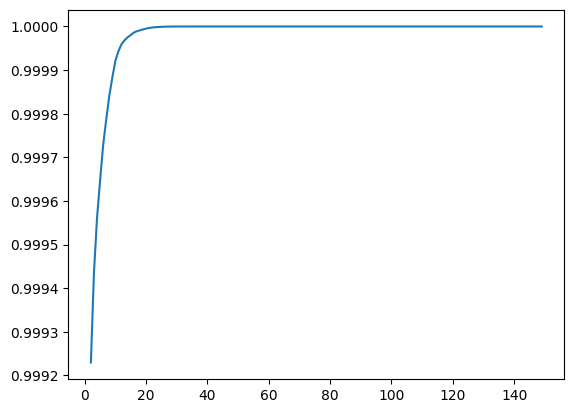

In [58]:
pd.Series(var_ratio).plot()

<Figure size 500x500 with 0 Axes>

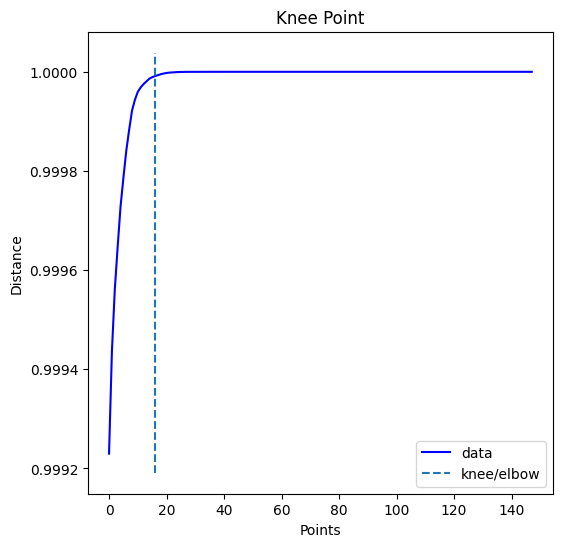

Knee Locator k = 18


In [61]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio = list(var_ratio.values())
components = list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve='concave', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k = components[knee.knee]
print('Knee Locator k =', k)

In [62]:
pca_final=PCA(n_components=18,random_state=42).fit(X_res)
reduced = pca_final.fit_transform(X_pca)
X_res, y_res = smt.fit_resample(reduced, y)

In [63]:
report_pca = evaluate_model(X_res,y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9994
- F1 score: 0.9994
- Precision: 0.9997
- Recall: 0.9990
- Roc Auc Score: 0.9994
- COST: 14070.
----------------------------------
Model performance for Test set
- Accuracy: 0.9833
- F1 score: 0.9836
- Precision: 0.9768
- Recall: 0.9905
- Roc Auc Score: 0.9832
- COST: 35160.


Decision Tree
Model performance for Training set
- Accuracy: 0.9994
- F1 score: 0.9994
- Precision: 0.9999
- Recall: 0.9989
- Roc Auc Score: 0.9994
- COST: 16030.
----------------------------------
Model performance for Test set
- Accuracy: 0.9731
- F1 score: 0.9734
- Precision: 0.9711
- Recall: 0.9758
- Roc Auc Score: 0.9730
- COST: 87550.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9373
- F1 score: 0.9374
- Precision: 0.9340
- Recall: 0.9408
- Roc Auc Score: 0.9373
- COST: 843530.
----------------------------------
Model performance for Test set
- Accuracy: 0.9397
- F1 score: 0.9404
- Precision: 0.9398
- Recall: 0.9409
-

In [64]:
report_pca

,Model Name,Cost
0,Random Forest,35160
5,XGBClassifier,52000
6,CatBoosting Classifier,59610
1,Decision Tree,87550
4,K-Neighbors Classifier,99250
2,Gradient Boosting,212750
7,AdaBoost Classifier,305270
3,Logistic Regression,661860


##### Final Model

In [66]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names=["Model","Imputation_method","Total_cost"]
pt.add_row(["XGBClassifier","Simple Imputer Mean","1930"])
pt.add_row(["XGBClassifier","Knn-Imputer","3480"])
pt.add_row(["XGBClassifier","Simple Imputer Consant","3500"])
pt.add_row(["XGBClassifier","Mice","3570"])
pt.add_row(["XGBClassifier","Simple Imputer Median","6100"])
pt.add_row(["Random Forest","PCA","34160"])
print(pt)

+---------------+------------------------+------------+
|     Model     |   Imputation_method    | Total_cost |
+---------------+------------------------+------------+
| XGBClassifier |  Simple Imputer Mean   |    1930    |
| XGBClassifier |      Knn-Imputer       |    3480    |
| XGBClassifier | Simple Imputer Consant |    3500    |
| XGBClassifier |          Mice          |    3570    |
| XGBClassifier | Simple Imputer Median  |    6100    |
| Random Forest |          PCA           |   34160    |
+---------------+------------------------+------------+


#### Fitting the Final Model

In [67]:
final_model = XGBClassifier()
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1)
X_res, y_res = smt.fit_resample(X_mean, y)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)
final_model = final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [70]:
print("Final XGBoost Classifier Accuracy Score (Test) :", accuracy_score(y_test,y_pred))

Final XGBoost Classifier Accuracy Score (Test) : 0.9967213114754099


In [71]:
print("Final XGBoost Classifier Cost Metric(Test) :",total_cost(y_test, y_pred))

Final XGBoost Classifier Cost Metric(Test) : 1930


In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[7055,   43],
       [   3, 6929]], dtype=int64)

In [79]:
import pickle 
filename = 'final_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))